In [1]:
# https://www.kaggle.com/gzuidhof/full-preprocessing-tutorial

import numpy as np
import pandas as pd
import pydicom
import os
import scipy.ndimage
import matplotlib.pyplot as plt
import SimpleITK as sitk
from skimage import measure, morphology
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from pathlib import Path
import json
from preproc import load_scan, resample, plot_3d
from tqdm.notebook import tqdm

In [2]:
def visualize(arr):
    plt.figure(figsize=(24, 18))
    z_mid = arr.shape[2] // 2
    for i in range(48):
        z_offset = i - 24
        ax = plt.subplot(6, 8, i+1)
        plt.imshow(arr[:,:,z_mid + z_offset], cmap='gray')
    plt.show()

In [3]:
root = Path('/scratch/zc2357/cv/final/datasets/luna16')

with open(root / 'uid_to_subset.json') as f:
    uid_to_subset = json.load(f)

In [4]:
cases = [root / val / (key + '.mhd') for key, val in uid_to_subset.items()]

# Check whether HU outliers can be reasonably clipped
Clipping to -1000, 3000 looks reasonable.

In [5]:
outliers_idx = [124, 231, 282, 349, 546, 754, 760, 823]
outliers = [cases[i] for i in range(len(cases)) if i in outliers_idx]

  0%|          | 0/2 [00:00<?, ?it/s]

Loading
Resampling
Rendering


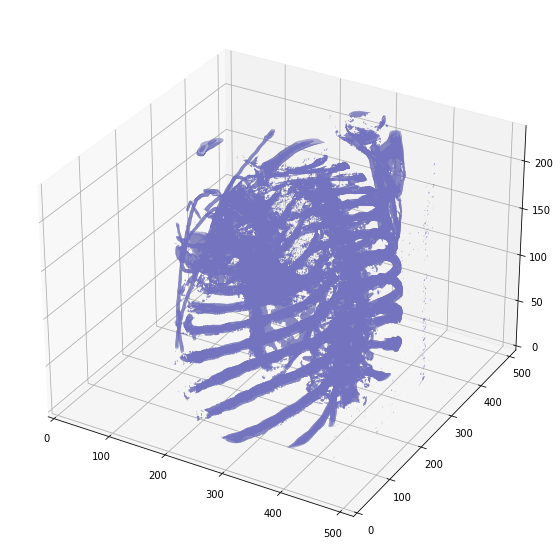

Loading
Resampling
Rendering


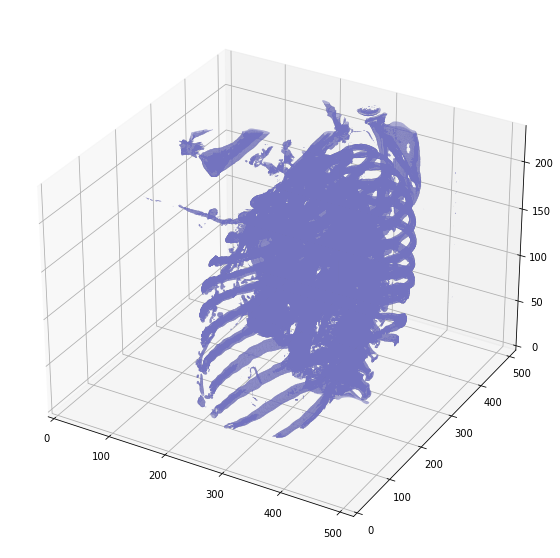

In [12]:
outliers_idx = []

for elem in tqdm(outliers[:2]):
    print('Loading')
    img, arr = load_scan(elem.as_posix())
    print('Resampling')
    arr_iso, spacing_iso = resample(arr, img.GetSpacing())
    print('Rendering')
    plot_3d(arr, threshold=400)

# Check whether all cases are (z, x, y) axes order
Yes. `load_scan` changes it to (x, y, z), and xsize == ysize == 512.

In [9]:
for elem in cases:
    img, arr = load_scan(elem.as_posix())
    print(arr.shape)

(512, 512, 109)
(512, 512, 117)
(512, 512, 195)
(512, 512, 325)
(512, 512, 244)
(512, 512, 276)
(512, 512, 140)
(512, 512, 221)
(512, 512, 280)
(512, 512, 119)
(512, 512, 147)
(512, 512, 157)
(512, 512, 250)
(512, 512, 133)
(512, 512, 369)
(512, 512, 120)
(512, 512, 195)
(512, 512, 280)
(512, 512, 516)
(512, 512, 176)
(512, 512, 151)
(512, 512, 730)
(512, 512, 246)
(512, 512, 129)
(512, 512, 300)
(512, 512, 471)
(512, 512, 483)
(512, 512, 474)
(512, 512, 127)
(512, 512, 127)
(512, 512, 545)
(512, 512, 229)
(512, 512, 481)
(512, 512, 280)
(512, 512, 147)
(512, 512, 538)
(512, 512, 152)
(512, 512, 133)
(512, 512, 157)
(512, 512, 246)
(512, 512, 129)
(512, 512, 204)
(512, 512, 733)
(512, 512, 127)
(512, 512, 297)
(512, 512, 123)
(512, 512, 123)
(512, 512, 280)
(512, 512, 209)
(512, 512, 141)
(512, 512, 250)
(512, 512, 465)
(512, 512, 280)
(512, 512, 124)
(512, 512, 194)
(512, 512, 197)
(512, 512, 325)
(512, 512, 404)
(512, 512, 429)
(512, 512, 140)
(512, 512, 245)
(512, 512, 392)
(512, 51

# Check candidates and candidates V2 number of samples

In [6]:
df = pd.read_csv('../datasets/luna16/candidates.csv')

In [7]:
df2 = pd.read_csv('../datasets/luna16/candidates_V2.csv')

In [25]:
pd.read_csv('../datasets/luna16/annotations.csv')

,seriesuid,coordX,coordY,coordZ,diameter_mm
0,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,-128.699421,-175.319272,-298.387506,5.651471
1,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,103.783651,-211.925149,-227.121250,4.224708
2,1.3.6.1.4.1.14519.5.2.1.6279.6001.100398138793...,69.639017,-140.944586,876.374496,5.786348
3,1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...,-24.013824,192.102405,-391.081276,8.143262
4,1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...,2.441547,172.464881,-405.493732,18.545150
...,...,...,...,...,...
1181,1.3.6.1.4.1.14519.5.2.1.6279.6001.994459772950...,-160.856298,-28.560349,-269.168728,5.053694
1182,1.3.6.1.4.1.14519.5.2.1.6279.6001.994459772950...,-102.189570,-73.865766,-220.536241,4.556101
1183,1.3.6.1.4.1.14519.5.2.1.6279.6001.994459772950...,-37.535409,64.041949,-127.687101,4.357368
1184,1.3.6.1.4.1.14519.5.2.1.6279.6001.997611074084...,43.196112,74.438486,-200.523314,4.277203


In [26]:
df['class'].value_counts()

0    549714
1      1351
Name: class, dtype: int64

In [27]:
df2['class'].value_counts()

0    753418
1      1557
Name: class, dtype: int64